In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# 1. Camera Calibration

In [2]:
# To get the object point and image point
def GetCordinatesForCalibration(filePath):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(filePath)
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = 'Calibration_Images/corners_found_'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            cv2.imshow('img', img)
            cv2.waitKey(500)
    cv2.destroyAllWindows()
    return objpoints,imgpoints

In [3]:
#To get the camera calibration matrix and distortion co-efficients
def calibrateCamera(objpoints,imgpoints,img_size):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret,mtx,dist

In [4]:
# To verify 'GetCordinatesForCalibration' method
objpoints,imgpoints=GetCordinatesForCalibration("camera_cal/calibration*.jpg")

print("Total Images : ", len(objpoints))

test_image=cv2.imread("Calibration_Images/corners_found_13.jpg")
img_size=(test_image.shape[1],test_image.shape[0])

# To verify 'calibrateCamera' method
ret,mtx,dist=calibrateCamera(objpoints,imgpoints,img_size)

print("Camera Calibration Matrix :")
print(mtx)
print("Distortion Co-Efficients :")
print(dist)

Total Images :  17
Camera Calibration Matrix :
[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Co-Efficients :
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318544e-04
    2.67124303e-02]]


# 2. Distortion Correction

In [5]:
# To un distort images
def un_distort(ImageFile):
    dst = cv2.undistort(ImageFile, mtx, dist, None, mtx)
    return dst

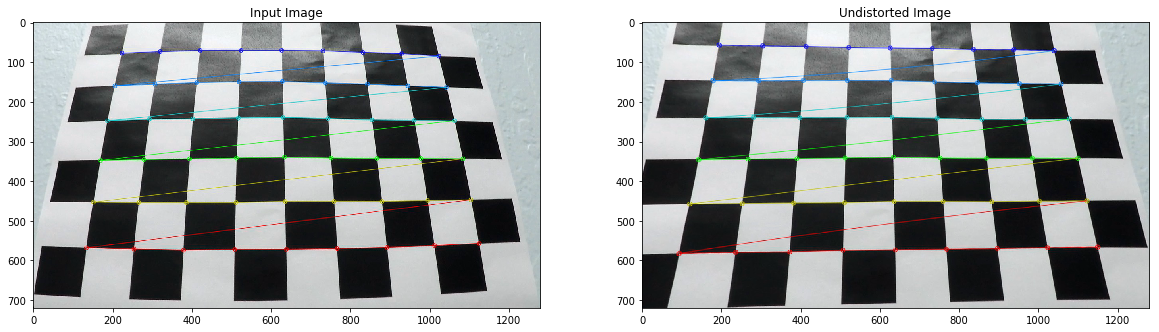

In [6]:
# To verify un_distort method 
Img="Calibration_Images/corners_found_13.jpg"
dst=un_distort(cv2.imread(Img))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title("Input Image")
ax2.imshow(dst)
ax2.set_title("Undistorted Image")

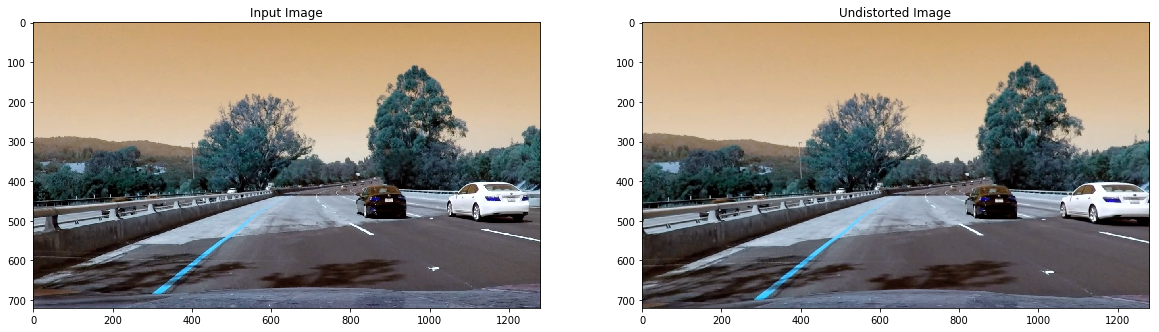

In [7]:
test_image_inp=cv2.imread("Images/InputFrame.jpg")
test_image=un_distort(test_image_inp)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(test_image_inp)
ax1.set_title("Input Image")
ax2.imshow(test_image)
ax2.set_title("Undistorted Image")

# 3. Color Thresholding
> ### Choose Color Channel
>> I have chose the RGB & HSV color spaces for performing color threshold. From the below output images, It is observed that `R Channel` from RGB and `S Channel` from HSV are good.
>> + R Channel : Good in detecting white lines
>> + S Channel : Helps in removing the effect of light variation

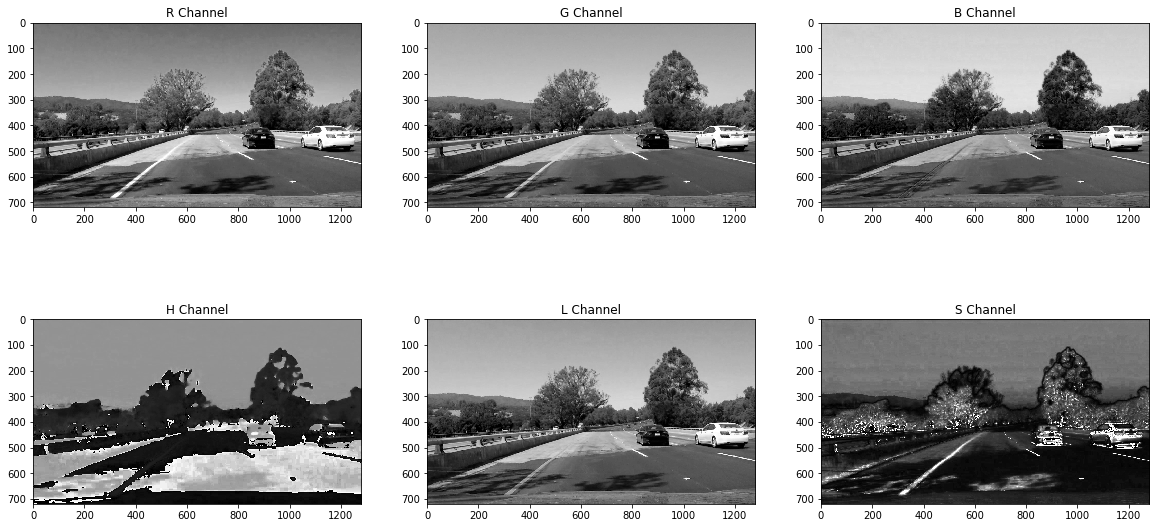

In [8]:
# First Image
test_image=cv2.imread("Images/InputFrame.jpg")
RGB_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
fig,ax=plt.subplots(2,3,figsize=(20,10))

ax[0][0].imshow(RGB_image[:,:,0],cmap="gray")
ax[0][0].set_title("R Channel")
ax[0][1].imshow(RGB_image[:,:,1],cmap="gray")
ax[0][1].set_title("G Channel")
ax[0][2].imshow(RGB_image[:,:,2],cmap="gray")
ax[0][2].set_title("B Channel")

HSL_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2HLS)

ax[1][0].imshow(HSL_image[:,:,0],cmap="gray")
ax[1][0].set_title("H Channel")
ax[1][1].imshow(HSL_image[:,:,1],cmap="gray")
ax[1][1].set_title("L Channel")
ax[1][2].imshow(HSL_image[:,:,2],cmap="gray")
ax[1][2].set_title("S Channel")

> ### Apply Color Threshold
>> Here, I am applying color thershold to get the required features from the selected channel

In [9]:
# Define Color threshold
def color_thresh(inp_img,thresh_low,thresh_high,sobel_KSize=3):
    out_img=np.zeros_like(inp_img)
    out_img[(inp_img>thresh_low)&(inp_img<=thresh_high)]=1
    return out_img

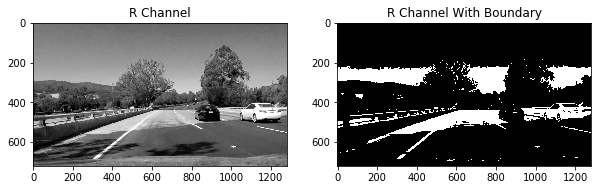

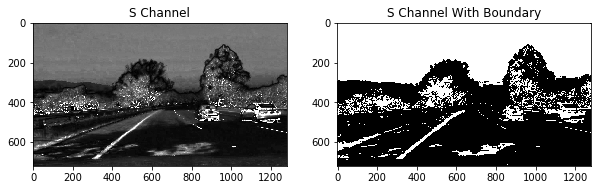

In [10]:
# Finding R Channel Boundary
R_low=160
R_high=255
R_Channel_in=RGB_image[:,:,0]
R_Channel_out=color_thresh(R_Channel_in,R_low,R_high)
fig,ax=plt.subplots(1,2,figsize=(10,20))
ax[0].set_title("R Channel")
ax[0].imshow(R_Channel_in,cmap="gray")
ax[1].set_title("R Channel With Boundary")
ax[1].imshow(R_Channel_out,cmap="gray")

# Finding S Channel Boundary
S_low = 83
S_high = 255
S_Channel_in=HSL_image[:,:,2]
S_Channel_out=color_thresh(S_Channel_in,S_low,S_high)
fig,ax=plt.subplots(1,2,figsize=(10,20))
ax[0].set_title("S Channel")
ax[0].imshow(S_Channel_in,cmap="gray")
ax[1].set_title("S Channel With Boundary")
ax[1].imshow(S_Channel_out,cmap="gray")

>>  After applyig color thershold, the lane lines are detected more clearly than the normal version. At the same time, it introduced some noises in the output image also.

> ### Combine Color Channel
>> The combination of R Channel and S channel will remove the noise as well as it will help to detect the lane lines in different condition

In [11]:
# Combining R & S
def Combine_RS(inp_img,R_Limit,S_Limit):
    RGB_img=cv2.cvtColor(inp_img,cv2.COLOR_BGR2RGB)
    R_Channel=RGB_img[:,:,0]
    R_Channel_out=color_thresh(R_Channel,R_Limit[0],R_Limit[1])
    
    HLS_img=cv2.cvtColor(inp_img,cv2.COLOR_BGR2HLS)
    S_Channel=HLS_img[:,:,2]
    S_Channel_out=color_thresh(S_Channel,S_Limit[0],S_Limit[1])
    
    out_img=np.zeros_like(R_Channel)
    out_img[(R_Channel_out==1)&(S_Channel_out==1)]=1
    return out_img

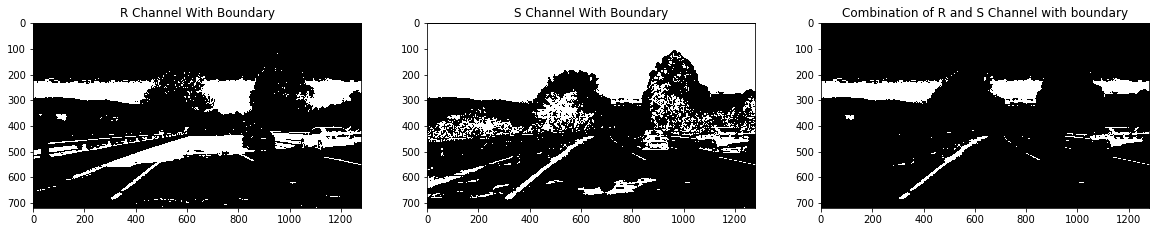

In [12]:
fig,ax=plt.subplots(1,3,figsize=(20,20))

R_Channel_in=RGB_image[:,:,0]
R_Channel_out=color_thresh(R_Channel_in,R_low,R_high)
ax[0].set_title("R Channel With Boundary")
ax[0].imshow(R_Channel_out,cmap="gray")

S_Channel_in=HSL_image[:,:,2]
S_Channel_out=color_thresh(S_Channel_in,S_low,S_high)
ax[1].set_title("S Channel With Boundary")
ax[1].imshow(S_Channel_out,cmap="gray")

Combine_out=Combine_RS(test_image,[R_low,R_high],[S_low,S_high])
ax[2].set_title("Combination of R and S Channel with boundary")
ax[2].imshow(Combine_out,cmap="gray")

## 4. Gradient Thresholding
>> Output of color thresholding is good to detect lane lines. But to further improve the quality, we are performing gradient thershold. Here `Sobel` operator is used for finding gradient of the image. 

>> We can perform gradient thershold by ***THREE*** ways. They are `Sobel X`, `Sobel Y` and `Sobel XY`.

>> We can apply both magnitude as well as direction thershold on each of the above Sobel operator

In [13]:
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2), mag_thresh=(10,100), orient="mag"):
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    gradX=cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    gradY=cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    # Angle Calculation
    abs_gradX=np.absolute(gradX)
    abs_gradY=np.absolute(gradY)
    
    # Determining Orientation
    if orient=="x":
        mag=np.uint8(abs_gradX/np.max(abs_gradX)*255.0)
    elif orient == "y":
        mag=np.uint8(abs_gradY/np.max(abs_gradY)*255.0)
    else:
        mag=((abs_gradX**2)+(abs_gradY**2))**0.5
        mag=np.uint8(mag/np.max(mag)*255.0)
    
    direction=np.arctan2(abs_gradY, abs_gradX)
    
    binary_output=np.zeros_like(direction)
    binary_output[(mag>mag_thresh[0])&(mag<=mag_thresh[1])&(direction>dir_thresh[0])&(direction<=dir_thresh[1])]=1
    
    return binary_output

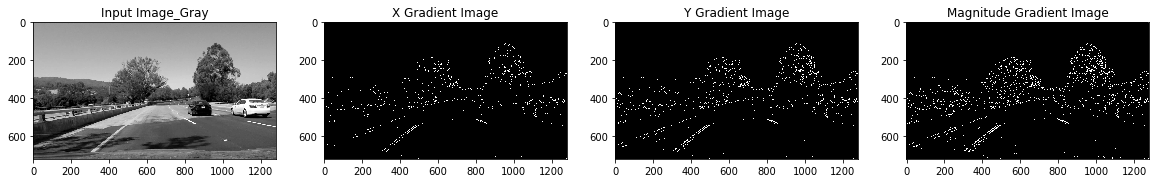

In [14]:
fig,ax=plt.subplots(1,4,figsize=(20,20))
inp_img = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)

ax[0].set_title("Input Image_Gray")
ax[0].imshow(inp_img,cmap="gray")

gradX=dir_threshold(inp_img,sobel_kernel=5,dir_thresh=(0.65,1.15),mag_thresh=(25,250),orient="x")
ax[1].set_title("X Gradient Image")
ax[1].imshow(gradX,cmap="gray")

gradY=dir_threshold(inp_img,sobel_kernel=5,dir_thresh=(0.65,1.15),mag_thresh=(25,250),orient="y")
ax[2].set_title("Y Gradient Image")
ax[2].imshow(gradY,cmap="gray")

mag=dir_threshold(inp_img,sobel_kernel=5,dir_thresh=(0.65,1.15),mag_thresh=(25,250),orient="mag")
ax[3].set_title("Magnitude Gradient Image")
ax[3].imshow(mag,cmap="gray")

## 5. Combine Color & Gradient Threshold
>> The combination of R & S channel, Magnitude gradient thershold is selected from color & gradient thersholding techniques respectively. 
>> They were combined using `OR gate`, as we don't want to lose any input informations.

In [15]:
# To combine gradient with color thresh hold
def combine_Gradient_Color(Grad_img,Color_img):
    out_img=np.zeros_like(Grad_img)
    out_img[(Grad_img==1)|(Color_img==1)]=1
    return out_img

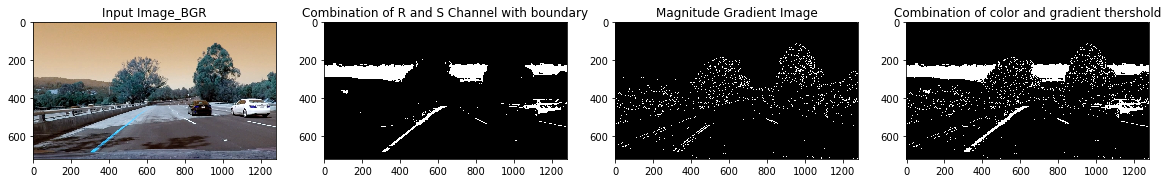

In [16]:
fig,ax=plt.subplots(1,4,figsize=(20,20))
grad_inp = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)

ax[0].set_title("Input Image_BGR")
ax[0].imshow(test_image)

Color_out=Combine_RS(test_image,[R_low,R_high],[S_low,S_high])
ax[1].set_title("Combination of R and S Channel with boundary")
ax[1].imshow(Color_out,cmap="gray")

Grad_out=dir_threshold(grad_inp,sobel_kernel=5,dir_thresh=(0.65,1.15),mag_thresh=(25,250),orient="mag")
ax[2].set_title("Magnitude Gradient Image")
ax[2].imshow(Grad_out,cmap="gray")

combination_out=combine_Gradient_Color(Grad_out,Color_out)
ax[3].set_title("Combination of color and gradient thershold")
ax[3].imshow(combination_out,cmap="gray")

> ### Converting Input Image To Binary Out

In [17]:
# To get the binary output of the input frame
def cvtToBinary(InpImg):    
    # Perform Color & Gradient Thershold
    Color_out=Combine_RS(InpImg,[R_low,R_high],[S_low,S_high])
    grad_inp=cv2.cvtColor(InpImg,cv2.COLOR_BGR2GRAY)
    Grad_out=dir_threshold(grad_inp,sobel_kernel=5,dir_thresh=(0.65,1.15),mag_thresh=(25,250),orient="mag")
    
    # Combine the output
    binary_out=combine_Gradient_Color(Grad_out,Color_out)
    return binary_out 

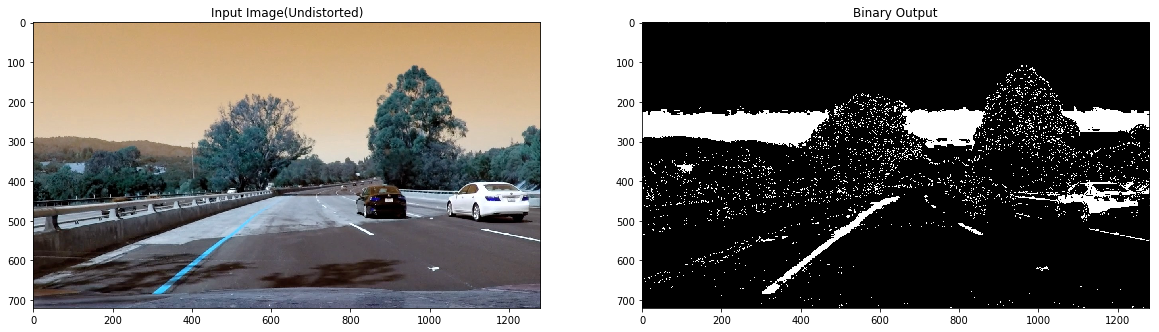

In [18]:
# Verification of "cvtToBinary" function
fig,ax=plt.subplots(1,2,figsize=(20,20))

sample_out=cvtToBinary(test_image)
ax[0].imshow(test_image,cmap="gray")
ax[0].set_title("Input Image(Undistorted)")
ax[1].imshow(sample_out,cmap="gray")
ax[1].set_title("Binary Output")

## 6. Perspective Transform

In [19]:
src=np.float32([[770,461],[1250,657],[193,667],[567,461]])
dest=np.float32([[1250,29],[1250,657],[193,667],[193,29]])

def ImageWrapper(BinaryIn,src,dest,img_size=(1280,720)):
    M = cv2.getPerspectiveTransform(src, dest)
    warpedImage = cv2.warpPerspective(BinaryIn, M, img_size, flags=cv2.INTER_LINEAR)
    return warpedImage

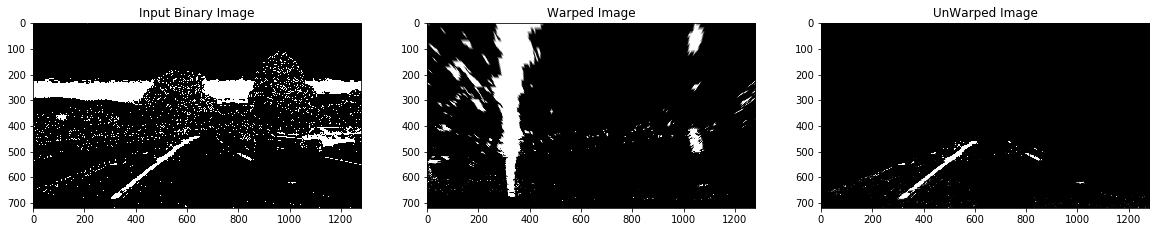

In [20]:
fig,ax=plt.subplots(1,3,figsize=(20,20))
ax[0].set_title("Input Binary Image")
ax[0].imshow(sample_out,cmap="gray")

# Verification of warper (source to destination)
Warp=ImageWrapper(sample_out,src,dest,img_size=(1280,720))
ax[1].set_title("Warped Image")
ax[1].imshow(Warp,cmap="gray")

# Verification of warper (destination to source)
UnWarp=ImageWrapper(Warp,dest,src)
ax[2].set_title("UnWarped Image")
ax[2].imshow(UnWarp,cmap="gray")


## 7. Finding Lane On Warped Image

In [21]:
# To get the next point in the given sample line
def nextPoint(BinaryImg,CurrentPoint_X,Y,Offset):
    NonZero=np.array(np.nonzero(BinaryImg[Y][CurrentPoint_X-Offset:CurrentPoint_X+Offset]))
    #print(len(NonZero[0])
    
    if (len(NonZero[0])!=0)and(len(NonZero[0])>5):
        Average_X=np.uint16(np.average(NonZero)+CurrentPoint_X)-Offset
        All_X=np.uint16(NonZero+CurrentPoint_X-Offset)
        return True,All_X[0],Average_X
    else:
        return False,0,CurrentPoint_X

In [22]:
# To get the co ordinates of Left & Right lines
Sampling_Rate=50
def getCoOrdinates(WrappedImage,offset,left_baseX=0,right_baseX=0):
    # Creating Empty list for LEFT and Right lines
    LeftLine_X=[]
    LeftLine_Y=[]
    RightLine_X=[]
    RightLine_Y=[]
    
    # Fixing Constants
    mid=WrappedImage.shape[1]//2
    y_ax=WrappedImage.shape[0]
    window_height=y_ax//Sampling_Rate
    
    # To Get Base Value
    if (left_baseX==0 or right_baseX==0):
        hist=np.sum(WrappedImage[:,:],axis=0)
        left_baseX=np.argmax(hist[:mid])
        right_baseX=np.argmax(hist[mid:])+mid
    
    lx_mid=left_baseX
    rx_mid=right_baseX
    
    curr_rx=right_baseX
    curr_lx=left_baseX
        
    for i in range(Sampling_Rate):
        y=int(y_ax-(i+1)*window_height)
        
        flag,all_lx,curr_lx=nextPoint(WrappedImage,curr_lx,y,offset)
        if flag:
            for lx in all_lx:
                LeftLine_X.append(lx)
                LeftLine_Y.append(y)
                #plt.scatter(lx,y,c="r")
        #plt.plot((curr_lx-offset,curr_lx+offset),(y,y),linewidth=3,c="r")
        
        flag,all_rx,curr_rx=nextPoint(WrappedImage,curr_rx,y,offset)
        if flag:
            for rx in all_rx:
                RightLine_X.append(rx)
                RightLine_Y.append(y)
                #plt.scatter(rx,y,c="b")
        #plt.plot((curr_rx-offset,curr_rx+offset),(y,y),linewidth=3,c="b")
     
    return [LeftLine_X,LeftLine_Y],[RightLine_X,RightLine_Y],curr_lx,curr_rx

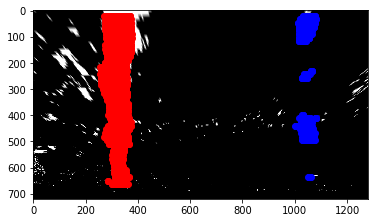

In [23]:
Left,Right,Left_Base,Right_Base=getCoOrdinates(Warp,50)#WarpedImage#Warp
plt.imshow(Warp,cmap="gray")
plt.scatter(Left[0],Left[1],c="r")
plt.scatter(Right[0],Right[1],c="b")

In [24]:
def CoOrdinateCorrection(LineList,currentList,Lenght_Y):
    global max_y,thershold_y
    x_val=LineList[0]
    y_val=LineList[1]
        
    curr_x_val=currentList[0]
    curr_y_val=currentList[1]
    
    if (len(y_val)==0|len(x_val)==0):
        # New Frame
        y_val=y_val+curr_y_val
        x_val=x_val+curr_x_val
        
    elif len(set(curr_y_val))>=int(0.50*Sampling_Rate) :
        # new frame detected more than 50% of sampling line
        y_val=curr_y_val
        x_val=curr_x_val
        
    elif len(set(curr_y_val))>=int(0.30*Sampling_Rate) :
        # new frame detected more than 20% of sampling line but less than 50%
        
        # 1. Finding Polynomial for current data
        Polynomial=np.polyfit(curr_y_val, curr_x_val, 2)
        y1_val= np.unique(curr_y_val)
        x1_val= Polynomial[0]*y1_val**2+Polynomial[1]*y1_val+Polynomial[2]
        
        # 2. Calculate only 10% of old data
        Polynomial=np.polyfit(y_val, x_val, 2)
        needed_ind=int(0.10*Lenght_Y)
        y2_val= np.linspace(Lenght_Y,Lenght_Y+needed_ind,needed_ind)
        x2_val= Polynomial[0]*y2_val**2+Polynomial[1]*y2_val+Polynomial[2]
        # 3. Concatenating the old data with new data
        y_val= np.concatenate((y1_val,y2_val),axis=0)
        x_val= np.concatenate((x1_val,x2_val),axis=0)
    
    elif len(set(curr_y_val))>=int(0.20*Sampling_Rate) :
        # new frame detected more than 20% of sampling line but less than 50%
        
        # 1. Finding Polynomial for current data
        Polynomial=np.polyfit(curr_y_val, curr_x_val, 2)
        y1_val= np.unique(curr_y_val)
        x1_val= Polynomial[0]*y1_val**2+Polynomial[1]*y1_val+Polynomial[2]
        # 2. Calculate only 10% of old data
        Polynomial=np.polyfit(y_val, x_val, 2)
        needed_ind=int(0.30*Lenght_Y)
        y2_val= np.linspace(Lenght_Y,Lenght_Y+needed_ind,needed_ind)
        x2_val= Polynomial[0]*y2_val**2+Polynomial[1]*y2_val+Polynomial[2]
        # 3. Concatenating the old data with new data
        y_val= np.concatenate((y1_val,y2_val),axis=0)
        x_val= np.concatenate((x1_val,x2_val),axis=0)
        
    elif len(curr_y_val)!=0:
        # Ambiguous stage ( Only less than 20% of data are captured from the current frame )
        
        # 1. Finding the current frame data
        Polynomial=np.polyfit(curr_y_val, curr_x_val, 2)
        y1_val= np.unique(curr_y_val)
        x1_val= Polynomial[0]*y1_val**2+Polynomial[1]*y1_val+Polynomial[2]
        # 2. Appending the data with last frame details
        #y_val= np.array(y_val)+Lenght_Y
        y_val= np.concatenate((y_val,y1_val),axis=0)
        x_val= np.concatenate((x_val,x1_val),axis=0)
        
    elif len(curr_y_val)==0 :
        # new frame detected nothing
        curr_y_val=None
        curr_x_val=None
    
    return [x_val,y_val]   

In [25]:
# To plot the line on the given frame
CumulativeLeft = [[],[]]
CumulativeRight = [[],[]]
def DrawLines(WrappedImage):
    # Get the line co ordinates from current frame
    global CumulativeLeft,CumulativeRight
    CurrentLeft,CurrentRight,Left_Base,Right_Base=getCoOrdinates(WrappedImage,50)
    
    # Co-Ordinates correction (Running Average)
    Left=CoOrdinateCorrection(CumulativeLeft,CurrentLeft,WrappedImage.shape[0])
    Right=CoOrdinateCorrection(CumulativeRight,CurrentRight,WrappedImage.shape[0])
    
    # Getting The polynomial co-efficients for Left & Right lines
    LeftFit=np.polyfit(Left[1], Left[0], 2)
    RightFit=np.polyfit(Right[1], Right[0], 2)
    
    # Creating Final Left & Right Co-Ordinates
    y_val=np.linspace(0,WrappedImage.shape[0]-1,WrappedImage.shape[0])
    
    left_x=LeftFit[0]*y_val**2+LeftFit[1]*y_val+LeftFit[2]
    right_x=RightFit[0]*y_val**2+RightFit[1]*y_val+RightFit[2]
    
    # Update Cumulative Vector
    CumulativeLeft=[left_x,y_val]
    CumulativeRight=[right_x,y_val]
    
    return y_val,left_x,right_x   

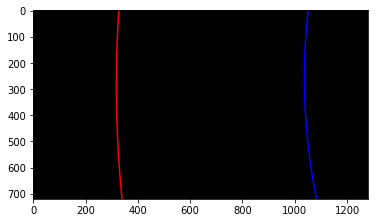

In [26]:
y_val,left_x,right_x =DrawLines(Warp)#WarpedImage#Warp
#plt.imshow(Warp,cmap="gray")
xc=np.zeros(Warp.shape)
fig,ax=plt.subplots(1,1)
ax.imshow(xc,cmap="gray")
ax.plot(left_x,y_val,c="r")
ax.plot(right_x,y_val,c="b")

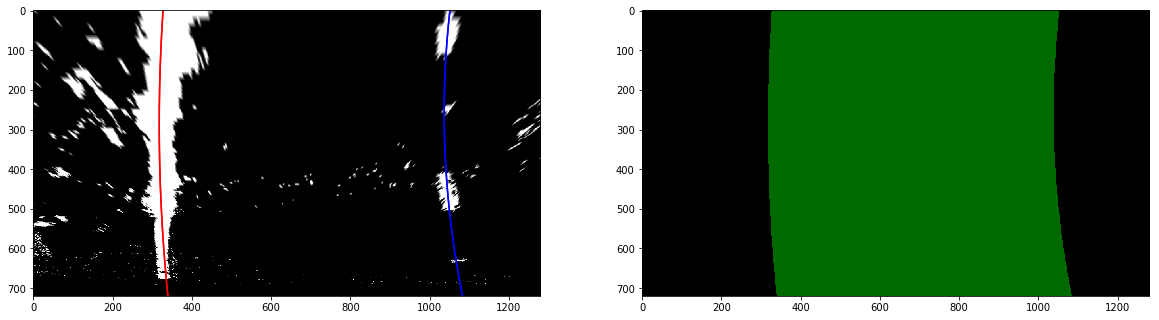

In [27]:
# To get the colored lane line
def FindLanes(WrappedImage):
    global AvgLeft,AvgRight
    # Get the Lane Lines
    y_val,left_x,right_x=DrawLines(WrappedImage)
    
    # Creating Empty Image
    temp=np.zeros_like(WrappedImage)
    color_warp = np.dstack((temp, temp, temp))
    
    # Creating Points For Left & Right Lanes
    pts_left = np.array([np.transpose(np.vstack([left_x, y_val]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, y_val])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,150, 0))
    return color_warp,y_val,left_x,right_x

color_Lane,y_val,left_x,right_x=FindLanes(Warp)
fid,ax=plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(Warp,cmap="gray")
ax[0].plot(left_x,y_val,c="r")
ax[0].plot(right_x,y_val,c="b")
ax[1].imshow(color_Lane)
ax[0].plot(left_x,y_val,c="r")
ax[0].plot(right_x,y_val,c="b")

## 8. Updating Input Image

In [28]:
def UpdateLane(InputFrame_Undist,ColoredLane):
    img_size=(InputFrame_Undist.shape[1],InputFrame_Undist.shape[0])
    UnWarp=ImageWrapper(ColoredLane,dest,src,img_size=img_size)
    UnWarp=np.uint8(UnWarp)
    OutputImage = cv2.addWeighted(InputFrame_Undist, 1, UnWarp, 0.3, 0)
    return OutputImage

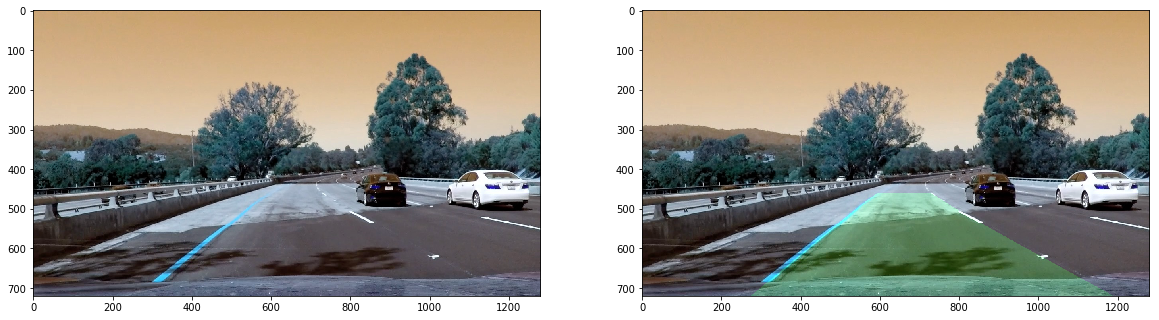

In [29]:
OutputImg=UpdateLane(test_image,color_Lane)
fid,ax=plt.subplots(1,2,figsize=(20,40))
ax[0].imshow(test_image)
ax[1].imshow(OutputImg)

### Calculating Radius of curvature

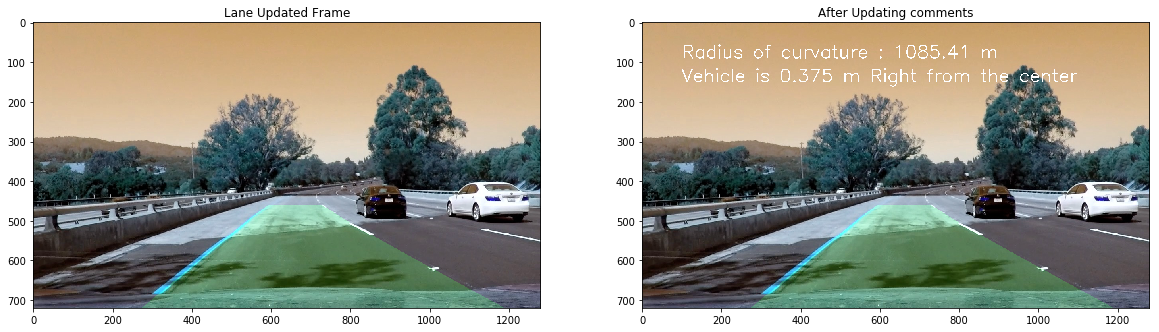

In [30]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def CalculateRadiusOfCurvature(Line):
    # 1. Seperating x,y axis    
    x_axis=Line[0]
    y_axis=Line[1]
    
    # 2. Calculating the co-efficient
    co_efficient = np.polyfit(y_axis*ym_per_pix, x_axis*xm_per_pix, 2)
    
    # 3. Calculating the curvature
    y_eval = np.max(y_axis)
    curverad = ((1 + (2*co_efficient[0]*y_eval*ym_per_pix + co_efficient[1])**2)**1.5) / np.absolute(2*co_efficient[0])
    
    return curverad

def UpdateComments(InputFrame):
    #global CumulativeLeft,CumulativeRight
    
    # 1. Calculate the left & right curvature
    LeftCurve=CalculateRadiusOfCurvature(CumulativeLeft)
    RightCurve=CalculateRadiusOfCurvature(CumulativeRight)
    
    # 2. Average curvature
    AverageCurve=(LeftCurve+RightCurve)/2.0
    curvature_string=("Radius of curvature : %.2f m"%AverageCurve)
    
    # 3. Calculate the deviation from the center
    LaneCenter = (CumulativeRight[0][719]+CumulativeLeft[0][719])//2
    ImageCenter = 640
    if ImageCenter > LaneCenter:
        Orient="Left"
    else:
        Orient="Right"
    Deviation=abs(ImageCenter-LaneCenter)*xm_per_pix
    offset_string=("Vehicle is %0.3f m %s from the center"%(Deviation,Orient))
    
    # 4. Updating the image
    img=np.copy(InputFrame)
    cv2.putText(img,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(img, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return img

result = UpdateComments(OutputImg)
fig,ax=plt.subplots(1,2,figsize=(20,20))
ax[0].set_title("Lane Updated Frame")
ax[0].imshow(OutputImg)
ax[1].set_title("After Updating comments")
ax[1].imshow(result)

## Compressing the whole process into one method

In [31]:

def Update_Frame(CurrentFrame):
    # Convert the input image to Binary Out
    CurrentFrame=cv2.cvtColor(CurrentFrame,cv2.COLOR_RGB2BGR)
    Undist_Inp=un_distort(CurrentFrame)
    Binary_Out=cvtToBinary(Undist_Inp)

    # Perspective transform
    WarpedImage=ImageWrapper(Binary_Out,src,dest,img_size=(1280,720))
    
    # Apply Mask
    cv2.rectangle(WarpedImage,(1100,350),(1280,720),(0,0,0),-1)
    
    # Find Lanes
    color_Lane,y_val,left_x,right_x=FindLanes(WarpedImage)

    # Update lanes
    UpdatedFrame=UpdateLane(Undist_Inp,color_Lane)
    
    # Update Comments
    ResultFrame=UpdateComments(UpdatedFrame)
    ResultFrame=cv2.cvtColor(ResultFrame,cv2.COLOR_BGR2RGB)
    
    return ResultFrame

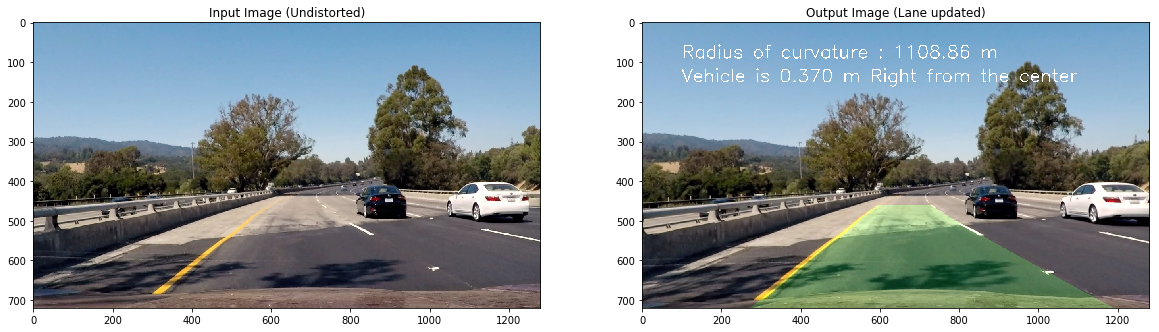

In [32]:
#To Verify the full pipe line
input_frame=cv2.imread("Images/InputFrame.jpg")
input_frame=cv2.cvtColor(input_frame,cv2.COLOR_RGB2BGR)
UpdatedFrame=Update_Frame(input_frame)
fid,ax=plt.subplots(1,2,figsize=(20,20))
ax[0].set_title("Input Image (Undistorted)")
ax[0].imshow(input_frame)
ax[1].set_title("Output Image (Lane updated)")
ax[1].imshow(UpdatedFrame)

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
# Reset the running average of left & right line
CumulativeLeft = [[],[]]
CumulativeRight = [[],[]]
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(Update_Frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:02<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 7min 4s


## Output Video

<video width="920" height="340" controls src="test_videos_output/project_video.mp4" />

In [35]:
# Reset the running average of left & right line
CumulativeLeft = [[],[]]
CumulativeRight = [[],[]]

In [36]:
white_output = 'test_videos_output/challenge_video.mp4'
clip1 = VideoFileClip("test_videos/challenge_video.mp4")
white_clip = clip1.fl_image(Update_Frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:41<00:00,  2.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 2min 43s


<video width="920" height="340" controls src="test_videos_output/challenge_video.mp4" />